In [1]:
# General Dependencies
import os
import numpy as np

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose,\
                        batch_recompose,\
                        overlapping_batch_decompose,\
                        overlapping_batch_recompose
from trefide.reformat import overlapping_component_reformat

# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import play_cv2

# Set Demo Dataset Location
ext = os.path.join("..", "..", "data")
filename = os.path.join(ext, "demoMovie.npy")

%load_ext autoreload
%autoreload 2

# Load Preprocessed Data

In [2]:
mov = np.load(filename)
fov_height, fov_width, num_frames = mov.shape

# Set Params

In [3]:
# Generous maximum of rank 50 blocks (safeguard to terminate early if this is hit)
max_components = 50

# Enable Decimation 
max_iters_main = 10
max_iters_init = 40
d_sub=2
t_sub=2

# Defaults
consec_failures = 3
tol = 5e-3

# Set Blocksize Parameters
block_height = 40
block_width = 40
overlapping = True

# Compress Video

## Simulate Critical Region Using Noise

In [4]:
def compute_thresh(samples, conf=5):
    #mu = np.mean(samples)
    #std = np.sqrt(np.var(samples))
    #return (norm.ppf(conf) * std) + mu
    return np.percentile(samples, conf)
def tv_norm(image):
    return np.sum(np.abs(image[:,:-1] - image[:,1:])) + np.sum(np.abs(image[:-1,:] - image[1:,:]))

def spatial_test_statistic(component):
    d1, d2 = component.shape
    return (tv_norm(component) *d1*d2)/ (np.sum(np.abs(component)) * (d1*(d2-1) + d2 * (d1-1)))

def temporal_test_statistic(signal):
    return np.sum(np.abs(signal[2:] + signal[:-2] - 2*signal[1:-1])) / np.sum(np.abs(signal))

In [5]:
def determine_thresholds(mov_dims, block_dims, num_components, conf=5, plot=False):
    
    # Simulate Noise Movie
    noise_mov = np.ascontiguousarray(np.reshape(np.random.randn(np.prod(mov_dims)), mov_dims))
    
    # Perform Blockwise PMD Of Noise Matrix In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(mov_dims[0], mov_dims[1], mov_dims[2],
                                    noise_mov, block_dims[0], block_dims[1],
                                    1e3, 1e3,
                                    num_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)
    
    # Gather Test Statistics
    spatial_stat = []
    temporal_stat = []
    num_blocks = int((mov_dims[0] / block_dims[0]) * (mov_dims[1] / block_dims[1]))
    for block_idx in range(num_blocks): 
        for k in range(int(block_ranks[block_idx])):
            spatial_stat.append(spatial_test_statistic(spatial_components[block_idx,:,:,k]))
            temporal_stat.append(temporal_test_statistic(temporal_components[block_idx,k,:]))

    # Compute Thresholds
    spatial_thresh = compute_thresh(spatial_stat, conf=conf)
    temporal_thresh = compute_thresh(temporal_stat, conf=conf)
    
    if plot:
        fig, ax = plt.subplots(2,2,figsize=(8,8))
        ax[0,0].scatter(spatial_stat, temporal_stat, marker='x', c='r', alpha = .2)
        ax[0,0].axvline(spatial_thresh)
        ax[0,0].axhline(temporal_thresh)
        ax[0,1].hist(temporal_stat, bins=20, color='r')
        ax[0,1].axvline(temporal_thresh)
        ax[0,1].set_title("Temporal Threshold: {}".format(temporal_thresh))
        ax[1,0].hist(spatial_stat, bins=20, color='r')
        ax[1,0].axvline(spatial_thresh)
        ax[1,0].set_title("Spatial Threshold: {}".format(spatial_thresh))
        plt.show()
    
    return spatial_thresh, temporal_thresh

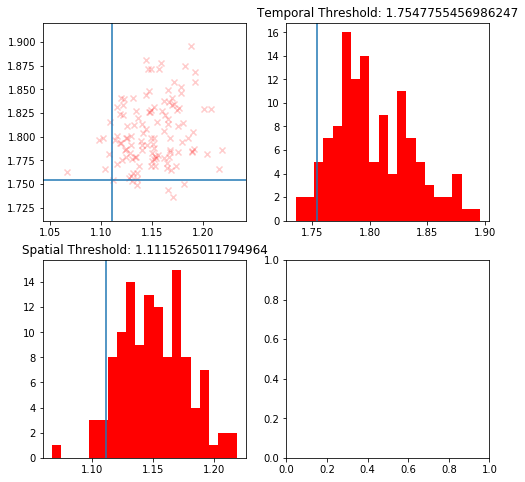

In [6]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Decompose Each Block Into Spatial & Temporal Components

In [7]:
if not overlapping:    # Blockwise Parallel, Single Tiling
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)
else:    # Blockwise Parallel, 4x Overlapping Tiling
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub=d_sub, t_sub=t_sub)

# Reconstruct Denoised Video

In [8]:
if not overlapping:  # Single Tiling (No need for reqweighting)
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:   # Overlapping Tilings With Reweighting
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

# Produce Diagnostics

### Single Tiling Pixel-Wise Ranks

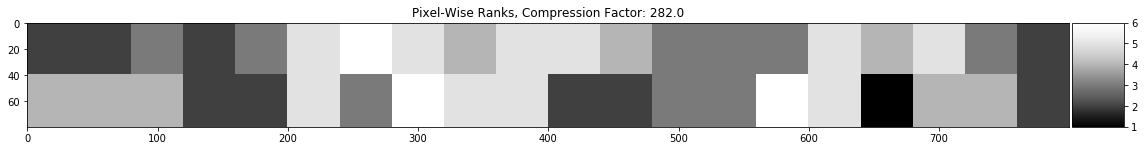

In [9]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Images

Local correlation:  range [-2.8e-02 5.2e-01]


/home/ian/devel/trefide/trefide/extras/noise_estimator.py:25: RuntimeWarning: divide by zero encountered in log
  'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(np.divide(Pxx_ind, 2)))))
/home/ian/devel/trefide/trefide/extras/util_plot.py:93: RuntimeWarning: divide by zero encountered in true_divide
  pnr = np.divide(data_max, data_std)
/home/ian/devel/trefide/trefide/extras/util_plot.py:93: RuntimeWarning: invalid value encountered in true_divide
  pnr = np.divide(data_max, data_std)
/home/ian/devel/trefide/trefide/extras/util_plot.py:97: RuntimeWarning: divide by zero encountered in true_divide
  tmp_data = Y / data_std[:,:,np.newaxis]
/home/ian/devel/trefide/trefide/extras/util_plot.py:97: RuntimeWarning: invalid value encountered in true_divide
  tmp_data = Y / data_std[:,:,np.newaxis]


Local correlation:  range [nan nan]
Local correlation:  range [-5.6e-02 6.7e-02]


/home/ian/devel/trefide/trefide/extras/util_plot.py:445: RuntimeWarning: invalid value encountered in less_equal
  if np.abs(img.min()) <= 1.5:


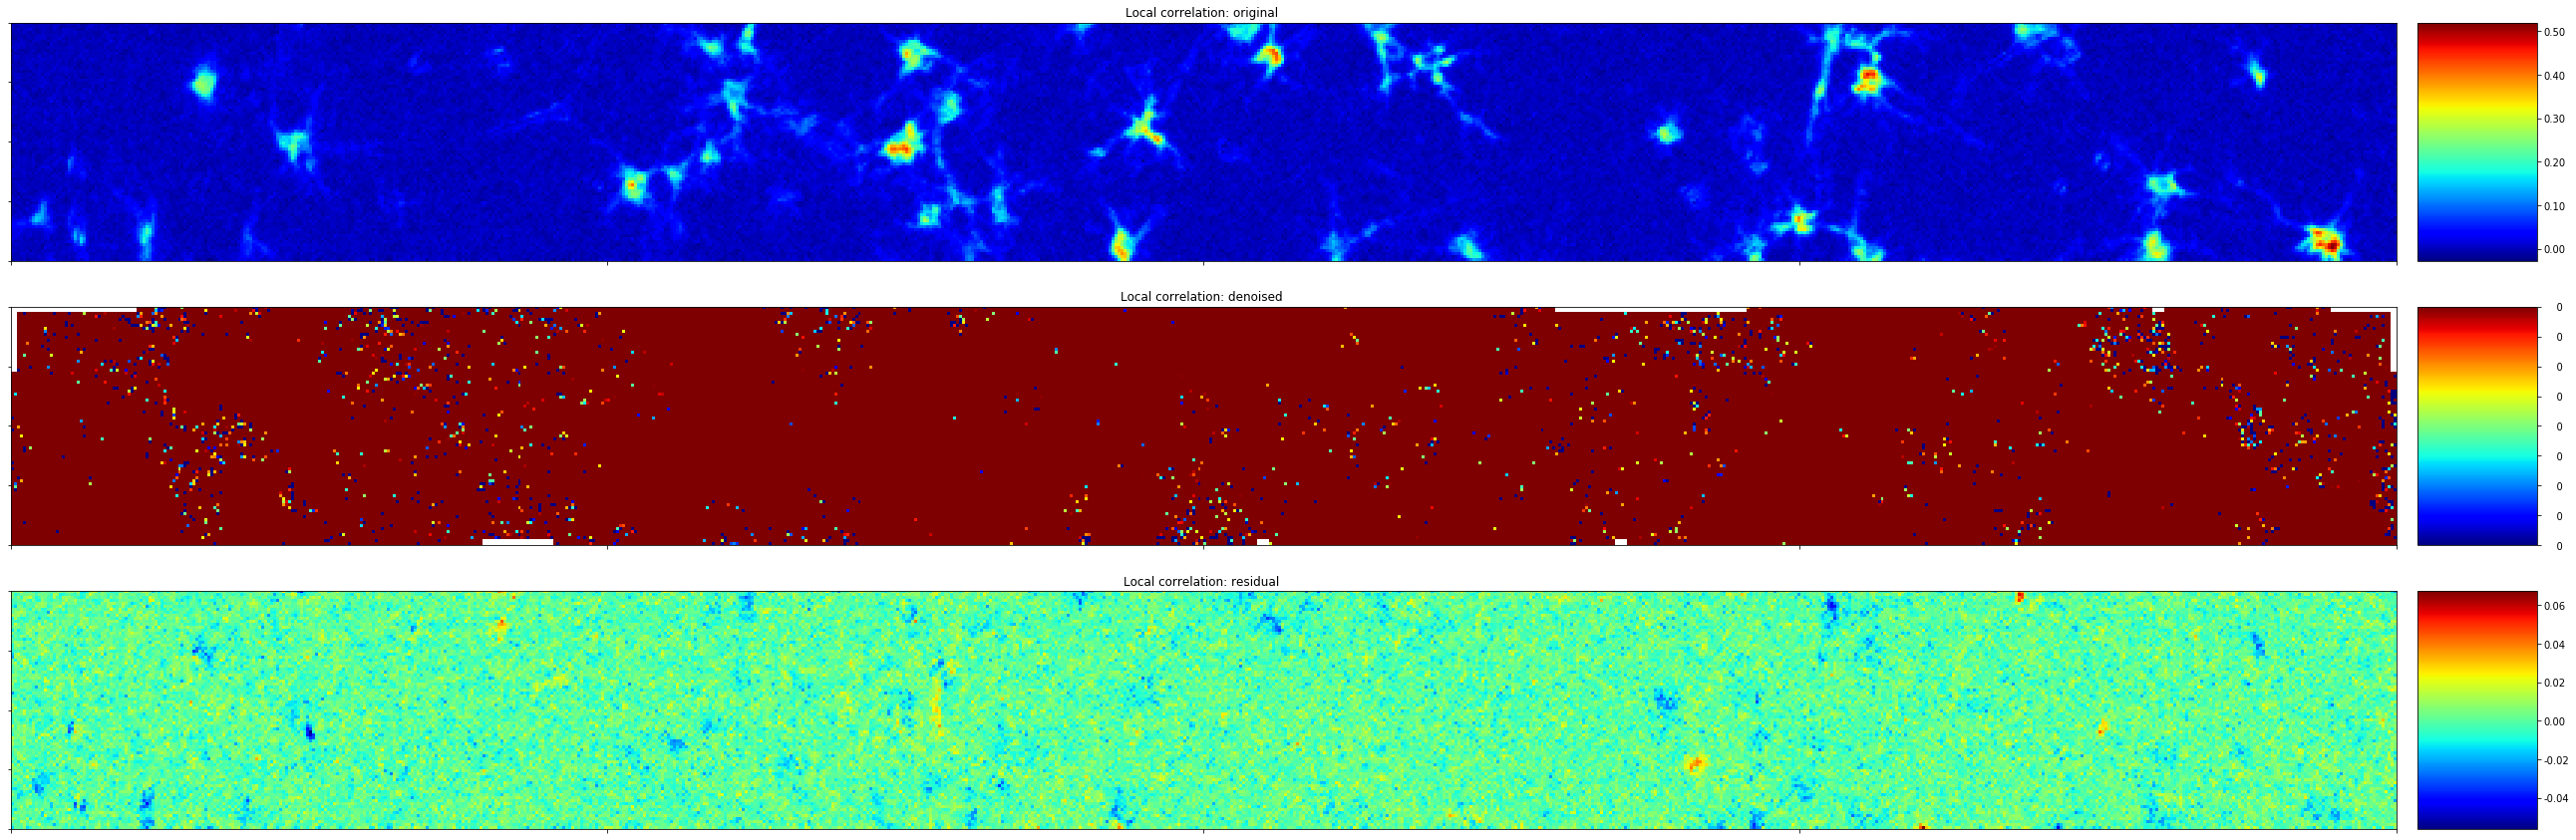

In [10]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Render Videos & Residual

In [11]:
play_cv2(np.vstack([mov, mov_denoised, mov-mov_denoised]), magnification=2)

# Save Results

In [12]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [14]:
np.savez(os.path.join(ext, "demo_results.npz"), U, V)